# Copyright Netherlands eScience Center <br>
** Function     : Verify the Arctic sea ice field in the Barents sea from ERA-Interim with NOAA/NSIDC passive microwave observation** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2020.07.30 ** <br>
** Last Update  : 2020.07.30 ** <br>
Description     : This notebook aims to verify the Arctic sea ice field in the Barents sea from ERA-Interim with NOAA/NSIDC passive microwave observation. <br>

The dataset consists of mulitple variables, but we only use the Merged GSFC NASA Team/Bootstrap daily sea ice concentrations from 1978 through most recent processing (variable name:"goddard_merged_seaice_conc"). It combines the results from two algorithms by NASA The details about these two algorithms are provided via the link:<br>
https://nsidc.org/support/faq/nasa-team-vs-bootstrap-algorithm

!!! It should be noticed that the data before 1987 is saved bi-daily and afterwards daily. We process them seperately and this script only works with structured data after 1987. For the missing dates, we simply use the historical mean.<br>

More information (incl. description of variables) is available through:<br>
https://nsidc.org/data/g02202

We also apply nearest neighbour interpolation to the ERA-Interim grid. We use the iris module.scipy function. An alternative can be the scipy module "scipy.interpolate.NearestNDInterpolator".<br>

Reference Meier, W. N., F. Fetterer, M. Savoie, S. Mallory, R. Duerr, and J. Stroeve. 2017. NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 3. Boulder, Colorado USA. NSIDC: National Snow and Ice Data Center. doi:
https://doi.org/10.7265/N59P2ZTG.<br>
Peng, G., W. N. Meier, D. Scott, and M. Savoie. 2013. A long-term and reproducible passive microwave sea ice concentration data record for climate studies and monitoring, Earth Syst. Sci. Data. 5. 311-318. https://doi.org/10.5194/essd-5-311-2013

Return Values   : netCDF4 <br>
Caveat          : <br>
The regionalization adopted here follows that of the MASIE (Multisensor Analyzed Sea Ice Extent) product available from the National Snow and Ice Data Center:<br>
https://nsidc.org/data/masie/browse_regions<br>
It is given by paper J.Walsh et. al., 2019. Benchmark seasonal prediction skill estimates based on regional indices.<br>

In [1]:
import numpy as np
import sys
import scipy as sp
import time as tttt
from netCDF4 import Dataset,num2date
import os
sys.path.append("C:\\Users\\nosta\\ML4Climate\\Scripts\\DLACs")
import dlacs
import dlacs.visual
import matplotlib
import cartopy
import cartopy.crs as ccrs

ModuleNotFoundError: No module named 'dlacs'

In [2]:
################################   Input zone  #########################################
# specify starting and ending time
# specify data path
# ERAI 3D fields on pressure level
datapath_ERAI = 'H:\\Creator_Zone\\Core_Database_DeepLearn\\ERA-Interim'
datapath_NSIDC = 'F:\\PhD_essential_data\\Core_Database_AMET_OMET_reanalysis\\NSIDC'
# specify output path for figures
output_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\Maps'
########################################################################################

In [3]:
print ('*********************** extract variables *************************')
dataset_ERAI_sic = Dataset(os.path.join(datapath_ERAI, 'sic_weekly_erai_1979_2017.nc'))
dataset_NSIDC_sic = Dataset(os.path.join(datapath_NSIDC, 'noaa_nsidc_weekly_regress_1989_2018_sic_passive_microwave.nc'))

# SIC ERA-Interim
SIC_ERAI = dataset_ERAI_sic.variables['sic'][10:,:,12:36,264:320] # 4D fields [year, week, lat, lon]
year_ERAI = dataset_ERAI_sic.variables['year'][10:]
week_ERAI = dataset_ERAI_sic.variables['week'][:]
latitude_ERAI = dataset_ERAI_sic.variables['latitude'][:]
longitude_ERAI = dataset_ERAI_sic.variables['longitude'][:]

# SIC NSIDC
SIC_NSIDC = dataset_NSIDC_sic.variables['sic'][:-1,:,12:36,264:320] # 4D fields [year, week, lat, lon]
year_NSIDC = dataset_NSIDC_sic.variables['year'][:-1]
latitude_NSIDC = dataset_NSIDC_sic.variables['latitude'][:]
longitude_NSIDC = dataset_NSIDC_sic.variables['longitude'][:]

*********************** extract variables *************************


In [4]:
print(year_ERAI)
print(year_NSIDC)
print(latitude_NSIDC)

[1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017]
[1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017]
[89.5  88.75 88.   87.25 86.5  85.75 85.   84.25 83.5  82.75 82.   81.25
 80.5  79.75 79.   78.25 77.5  76.75 76.   75.25 74.5  73.75 73.   72.25
 71.5  70.75 70.   69.25 68.5  67.75 67.   66.25 65.5  64.75 64.   63.25
 62.5  61.75 61.   60.25 59.5  58.75 58.   57.25 56.5  55.75 55.   54.25
 53.5  52.75 52.   51.25 50.5  49.75 49.   48.25 47.5  46.75 46.   45.25
 44.5  43.75 43.   42.25 41.5  40.75 40.  ]


In [5]:
print ('*********************** preprocessing *************************')
SIC_ERAI[SIC_ERAI<0] = 0
SIC_ERAI[SIC_ERAI>1.1] = 0
SIC_NSIDC[SIC_NSIDC<0] = 0
SIC_NSIDC[SIC_NSIDC>1.1] = 0

*********************** preprocessing *************************


*********************** check the difference and plot *************************
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


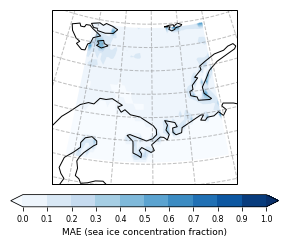

In [11]:
print ('*********************** check the difference and plot *************************')
diff = np.mean(np.mean(np.abs(SIC_ERAI - SIC_NSIDC), 0), 0)
label = 'MAE (sea ice concentration fraction)'
ticks = [i for i in np.linspace(0,1.0,11)]
dlacs.visual.plots.geograph(latitude_ERAI[12:36], longitude_ERAI[264:320],
                            diff, label, ticks,
                            os.path.join(output_path,'diff_sic_erai_nsidc_passiveMicrowave.png'),
                            boundary='Barents_Polar', colormap='Blues')